# AIF End-to-End Run Notebook

This notebook is meant for a new user to **run** the Automated Interpretation Framework (AIF) on one (or more) XRD patterns.

It supports two modes:
- **Display-only**: load precomputed interpretations from `interpretations.json` (no refinement, no LLM calls).
- **Full run**: run refinement + LLM evaluation + balance/prior/posterior + plots.

> Run this notebook from the **project root** (so `src/` and `data/` resolve correctly).


## 0. Setup paths

In [20]:
import sys, os, json, time, logging
from pathlib import Path
import pandas as pd

# Resolve project root
ROOT = Path.cwd()
if (ROOT / "src").exists():
    pass
elif (ROOT.parent / "src").exists():
    ROOT = ROOT.parent
else:
    raise RuntimeError("Couldn't find project root. Run from repo root or notebooks/.")

SRC = ROOT / "src"
sys.path.insert(0, str(SRC))

print("ROOT:", ROOT)
print("SRC:", SRC)


ROOT: /Users/odartsi/Documents/GitHub/AIF_copy
SRC: /Users/odartsi/Documents/GitHub/AIF_copy/src


## 1. Configure what you want to run

- Set `RUN_MODE = "display"` to load precomputed interpretations.
- Set `RUN_MODE = "full"` to run refinement + LLM + scoring.


In [21]:
RUN_MODE = "full"   # "display" or "full"
SAMPLE_KEY = "TRI_197"   # e.g. "TRI_197" (or "TRI-197" depending on your files)

# Dataset registry (edit/add as needed)
DATASETS = {
    "TRI": {
        "csv": ROOT / "data" / "xrd_data" / "synthesis_data.csv",
        "combos": ROOT / "data" / "xrd_data" / "difractogram_paths.json",
        "interpretations": ROOT / "data" / "xrd_data" / "interpretations" / "interpretations.json",
    }
}

GROUP = "TRI"  # which dataset group to use

assert GROUP in DATASETS, f"GROUP must be one of {list(DATASETS)}"
cfg = DATASETS[GROUP]
cfg


{'csv': PosixPath('/Users/odartsi/Documents/GitHub/AIF_copy/data/xrd_data/synthesis_data.csv'),
 'combos': PosixPath('/Users/odartsi/Documents/GitHub/AIF_copy/data/xrd_data/difractogram_paths.json'),
 'interpretations': PosixPath('/Users/odartsi/Documents/GitHub/AIF_copy/data/xrd_data/interpretations/interpretations.json')}

## 2. (Full run only) Configure LLM access

Your code currently expects these environment variables:

- `API_KEY` (required for LLM calls)
- *(recommended)* `API_BASE` (defaults to CBORG if your code supports it)
- *(recommended)* `MODEL` (defaults to your chosen deployment)

### If you are using CBORG
Typical values:
- `API_BASE = "https://api.cborg.lbl.gov"`
- `MODEL = "openai/gpt-4o"`

### If you are using OpenAI directly
Typical values:
- `API_BASE = "https://api.openai.com/v1"`
- `MODEL = "gpt-4o"` (or whatever you have access to)

This cell lets the user set these *inside the notebook* (no terminal export needed).


In [22]:
import os

if RUN_MODE == "full":
    #enter api key without quotes
    if not os.getenv("API_KEY"):
        os.environ["API_KEY"] = input("Enter API_KEY: ").strip()
    
    os.environ.setdefault("API_BASE", "https://api.cborg.lbl.gov")
    os.environ.setdefault("MODEL", "openai/gpt-4o")

    print("API_KEY set:", "YES" if os.getenv("API_KEY") else "NO")
    print("API_BASE:", os.getenv("API_BASE"))
    print("MODEL:", os.getenv("MODEL"))
else:
    print("RUN_MODE is 'display' -> skipping LLM configuration.")


API_KEY set: YES
API_BASE: https://api.cborg.lbl.gov
MODEL: openai/gpt-4o


In [ ]:
import os
# os.environ["API_KEY"] = 'sk-rxxr3gnNUFYf_aaV2w9DWA'
# os.environ["API_BASE"] = "https://api.cborg.lbl.gov"
# os.environ["MODEL"] = "openai/gpt-4o"

## 3. Load synthesis table + pattern registry

In [11]:
from utils import load_json, load_csv

df = load_csv(str(cfg["csv"]))
combos = load_json(str(cfg["combos"]))

print("Rows in synthesis CSV:", len(df))
print("Patterns in combos JSON:", len(combos))


Rows in synthesis CSV: 2
Patterns in combos JSON: 2


## 4. Select a pattern (by SAMPLE_KEY)

In [12]:
import os

def _normalize_key(k: str) -> str:
    return k.replace("-", "_")

sample_norm = _normalize_key(SAMPLE_KEY)

# Find a matching pattern_path entry
matches = [c for c in combos if _normalize_key(os.path.splitext(os.path.basename(c.get("pattern_path","")))[0]).startswith(sample_norm)]
if not matches:
    # fallback: contains
    matches = [c for c in combos if sample_norm in _normalize_key(c.get("pattern_path",""))]

if not matches:
    raise RuntimeError(f"No pattern found for SAMPLE_KEY={SAMPLE_KEY}. Try another key or inspect combos JSON.")

combo = matches[0]
pattern_path = combo["pattern_path"]
chemical_system = combo["chemical_system"]

# Pull synthesis row
filtered_df = df[df["Name"].astype(str).str.match(rf"^{sample_norm}$", na=False)]
if filtered_df.empty:
    filtered_df = df[df["Name"].astype(str).str.match(rf"^{sample_norm.replace('_','-')}$", na=False)]

if filtered_df.empty:
    raise RuntimeError(f"No synthesis row found for Name={SAMPLE_KEY} (normalized={sample_norm}) in CSV.")

target = filtered_df["Target"].iloc[0]

print("pattern_path:", pattern_path)
print("chemical_system:", chemical_system)
print("target:", target)
print("precursors:", filtered_df['Precursors'].iloc[0])


pattern_path: ../data/xrd_data/diffractogram/TRI-197.xrdml
chemical_system: Ca-V-C-O
target: CaVO2
precursors: ['CaCO3', 'V2O5']


## 5. Run AIF

- In **display** mode: loads `interpretations.json` and plots.
- In **full** mode: runs refinement + LLM + scoring and then plots.

Plots are shown inline (no file output).


In [13]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
from IPython.display import display

@contextmanager
def no_files_keep_figs():
    """Disable savefig and prevent close() so we can display figures in-notebook."""
    original_savefig = plt.savefig
    original_close = plt.close
    plt.savefig = lambda *args, **kwargs: None
    plt.close = lambda *args, **kwargs: None
    try:
        yield
    finally:
        plt.savefig = original_savefig
        plt.close = original_close


In [ ]:
import json, time, logging, warnings, contextlib, io
from pathlib import Path

from utils import (
    plot_metrics_contribution,
    plot_phase_and_interpretation_probabilities,
    normalize_scores_for_sample,
    normalize_rwp_for_sample,
    calculate_prior_probability,
    calculate_fit_quality,
    compute_trust_score,
    flag_interpretation_trustworthiness,
    calculate_posterior_probability_of_interpretation,
)

# Quiet notebook output
warnings.filterwarnings("ignore")
logging.getLogger().handlers.clear()
logging.basicConfig(
    level=logging.WARNING,  # <- was INFO; WARNING is much quieter
    format="%(asctime)s %(levelname)s: %(message)s",
    handlers=[logging.StreamHandler()],
)

t0 = time.time()

if RUN_MODE == "display":
    interp_path = cfg["interpretations"]
    if not Path(interp_path).exists():
        raise RuntimeError(f"interpretations file not found: {interp_path}")

    all_interpretations = json.loads(Path(interp_path).read_text())
    key = sample_norm
    if key not in all_interpretations and key.replace("_", "-") in all_interpretations:
        key = key.replace("_", "-")
    if key not in all_interpretations:
        raise RuntimeError(
            f"{SAMPLE_KEY} not found in interpretations file ({interp_path}). "
            "Switch RUN_MODE='full' to generate it."
        )

    interpretations = all_interpretations[key]

else:
    # Full run
    from refinement_metrics import calculate_spectrum_likelihood_given_interpretation_wrapper
    from LLM_evaluation import evaluate_interpretations_with_llm
    from composition_balance import calculate_chemical_factors

    # 1) Refinement metrics (BGMN/eflech) – capture noisy output so notebook stays clean
    try:
        result, project_number, target = calculate_spectrum_likelihood_given_interpretation_wrapper(
        combo["pattern_path"], combo["chemical_system"], target, alpha=1)

        if result:
            interpretations = calculate_chemical_factors(filtered_df, result)
            interpretations = evaluate_interpretations_with_llm(filtered_df, result, project_number)
            interpretations = calculate_chemical_factors(filtered_df,interpretations)
            interpretations = normalize_scores_for_sample(interpretations)
            interpretations = normalize_rwp_for_sample(interpretations)
            interpretations = calculate_prior_probability(interpretations, w_llm=0.5, w_bscore =0.7)
            interpretations = calculate_fit_quality(interpretations,w_rwp=1, w_score=0.5)
            interpretations = compute_trust_score(interpretations)
            interpretations = flag_interpretation_trustworthiness(interpretations)
            interpretations = calculate_posterior_probability_of_interpretation(interpretations)

            plot_phase_and_interpretation_probabilities(interpretations, project_number, filtered_df, target)
            plot_metrics_contribution(interpretations, project_number, target)
    except RuntimeError as e:
        msg = str(e)
        # Print a short actionable summary instead of the whole BGMN dump
        if "exit code is -11" in msg:
            print(
                "❌ BGMN crashed (segfault, exit code -11) during refinement metrics.\n"
                "This is a native-code crash (not Python/LLM). Common cause is missing "
                "instrument/VERZERR file or a bad temp run directory.\n"
                "Tip: search the error text for the temp folder path containing control.sav."
            )
        else:
            print("❌ Refinement step failed:", msg.splitlines()[0])
        raise  # stop here; to auto-skip failures you must patch the wrapper loop

print("Interpretations:", list(interpretations.keys()) if isinstance(interpretations, dict) else type(interpretations))
print("Elapsed:", round(time.time() - t0, 2), "sec")



Folder 'cifs' has been deleted.
Folder 'cifs' does not exist.
Skipping high-energy phase: 20351 (C, 229): e_hull = 0.7655
Skipping high-energy phase: 28858 (C, 227): e_hull = 0.115
Skipping high-energy phase: 29069 (C, 227): e_hull = 0.115
Skipping high-energy phase: 56902 (C, 4): e_hull = 1.5012
Skipping high-energy phase: 56904 (C, 62): e_hull = 0.2927
Skipping high-energy phase: 127080 (C, 62): e_hull = 0.2927
Skipping high-energy phase: 127094 (C, 62): e_hull = 0.2927
Skipping high-energy phase: 127095 (C, 62): e_hull = 0.2927
Skipping high-energy phase: 127096 (C, 62): e_hull = 0.2927
Skipping high-energy phase: 127097 (C, 62): e_hull = 0.2927
Skipping high-energy phase: 56905 (C, 14): e_hull = 1.0414
Skipping high-energy phase: 127088 (C, 14): e_hull = 1.0414
Skipping high-energy phase: 127106 (C, 14): e_hull = 1.0414
Skipping high-energy phase: 127109 (C, 14): e_hull = 1.0414
Skipping high-energy phase: 127111 (C, 14): e_hull = 1.0414
Skipping high-energy phase: 127118 (C, 14): 

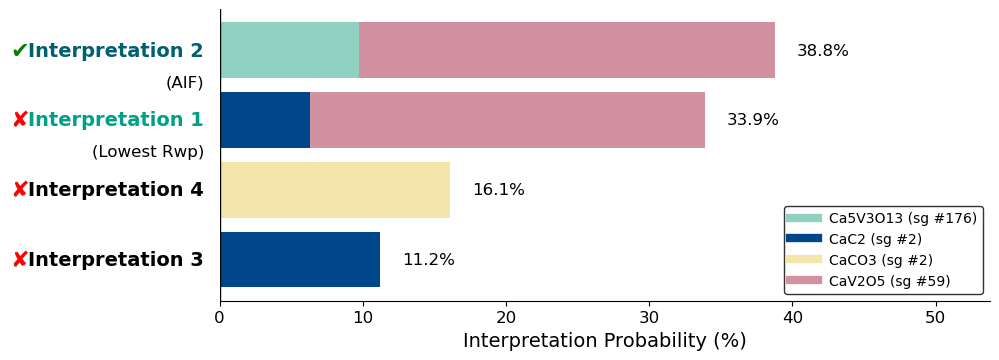

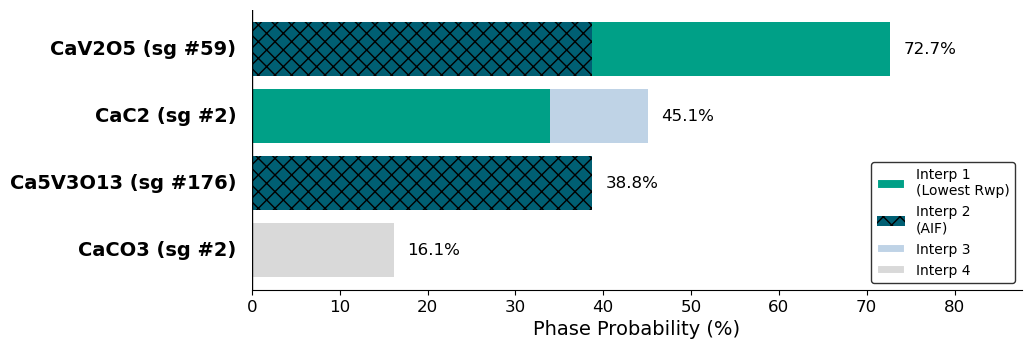

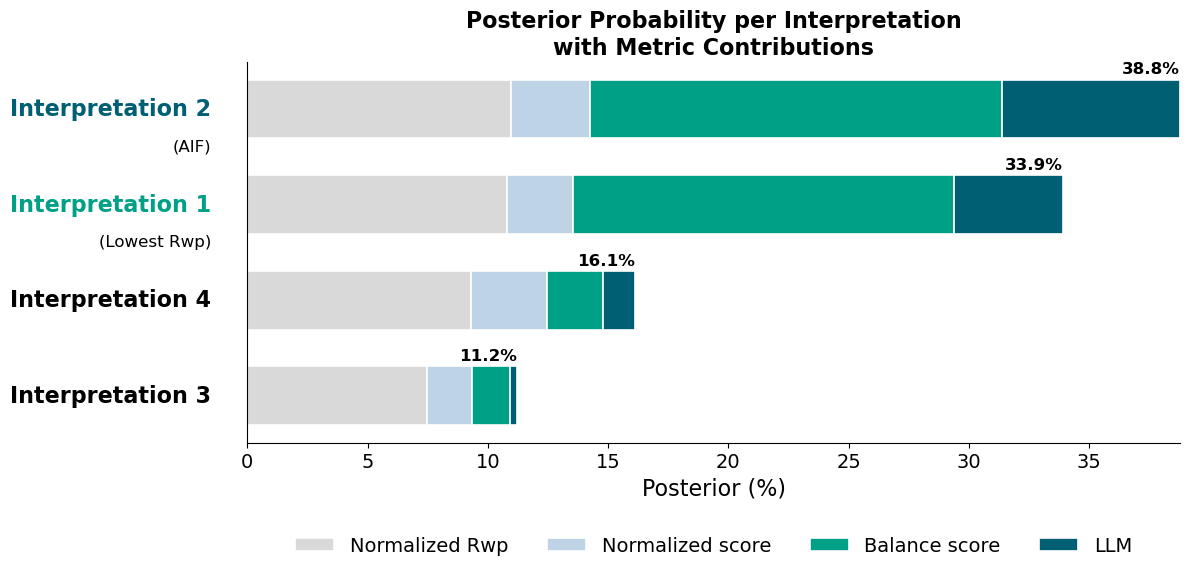

In [16]:
# Display plots inline
with no_files_keep_figs():
    plot_phase_and_interpretation_probabilities(interpretations, sample_norm, filtered_df, target)
    plot_metrics_contribution(interpretations, sample_norm, target)

# Let Jupyter render open figures once
plt.show()


## 6. Print a compact summary table

In [16]:
import pandas as pd

rows = []
for k, v in interpretations.items():
    rows.append({
        "interp": k,
        "phases": ", ".join(v.get("phases", [])),
        "LLM": v.get("LLM_interpretation_likelihood"),
        "balance": v.get("balance_score"),
        "rwp": v.get("rwp"),
        "norm_rwp": v.get("normalized_rwp"),
        "norm_score": v.get("normalized_score"),
        "prior": v.get("prior_probability"),
        "posterior": v.get("posterior_probability"),
        "trust": v.get("trust_score"),
        "trustworthy": v.get("trustworthy"),
    })

summary = pd.DataFrame(rows).sort_values("posterior", ascending=False)
summary


,interp,phases,LLM,balance,rwp,norm_rwp,norm_score,prior,posterior,trust,trustworthy
1,I_2,"CaV2O5_59, Ca5V3O13_176",0.6,0.9919,16.27,0.728833,0.437652,0.828608,0.387693,0.985889,True
0,I_1,"CaC2_2, CaV2O5_59",0.4,0.9984,16.16,0.730667,0.371643,0.749067,0.338948,0.983046,True
3,I_4,CaCO3_2,0.3,0.3750,17.39,0.710167,0.479508,0.343750,0.161219,0.866229,True
2,I_3,CaC2_2,0.1,0.3750,18.05,0.699167,0.346018,0.260417,0.112140,0.697867,True


(raylet) [2026-01-31 14:16:44,498 E 8761 49724281] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2026-01-31_13-52-23_787608_7579 is over 95% full, available space: 24706629632; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2026-01-31 14:16:54,591 E 8761 49724281] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2026-01-31_13-52-23_787608_7579 is over 95% full, available space: 21568229376; capacity: 494384795648. Object creation will fail if spilling is required.
